In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install import_ipynb
import import_ipynb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.6 MB/s eta 0:00:00


In [6]:
cd drive

/content/drive


In [7]:
cd MyDrive

/content/drive/MyDrive


In [8]:
cd fgsm\ 실습\ 폴더

/content/drive/MyDrive/fgsm 실습 폴더


In [9]:
#필수적인 패키지 임포트
from pyimagesearch.simplecnn import SimpleCNN
from pyimagesearch.fgsm import generate_image_adversary
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
import numpy as np
import cv2

importing Jupyter notebook from /content/drive/MyDrive/fgsm 실습 폴더/pyimagesearch/simplecnn.ipynb
importing Jupyter notebook from /content/drive/MyDrive/fgsm 실습 폴더/pyimagesearch/fgsm.ipynb


In [10]:
# MNIST 데이터셋을 로드하고 픽셀의 값을 [0,1]의 범위로 한다.
print("[INFO] loading MNIST dataset...")
(trainX,trainY),(testX,testY)=mnist.load_data()
trainX=trainX/255.0
testX=testX/255.0

# 이미지에 채널 차원 추가
trainX=np.expand_dims(trainX, axis=-1)
testX=np.expand_dims(testX,axis=-1)

#라벨을 원핫인코딩 시킨다.
trainY=to_categorical(trainY,10)
testY=to_categorical(testY,10)

[INFO] loading MNIST dataset...
11490434/11490434 [==============================] - 0s 0us/step


1. 픽셀을 [0,255] 범위에서 [0,1]로 조정
2. 이미지에 배치 차원 추가
3. 라벨을 원핫인코딩 시킨다

trainX를 trainY와 가깝게 학습시킨다.

In [11]:
#optimizer(최적화 함수)와 모델 초기화
print("[INFO] compiling model...")
opt = Adam(lr=1e-3)
model= SimpleCNN.build(width=28, height=28, depth=1, classes=10)
model.compile(loss="categorical_crossentropy",optimizer=opt,
              metrics=["accuracy"])

# 간단한 cnn과 mnist를 훈련시킨다
print("[INFO] training network...")
model.fit(trainX,trainY,
          validation_data=(testX,testY),
          batch_size=64,
          epochs=10,
          verbose=1)

#훈련된 모델에 대한 테스트 세트의 예측 수행
#비적대적 이미지들
(loss,acc)=model.evaluate(x=testX,y=testY,verbose=0)
print("[INFO] loss: {:.4f}, acc: {:.4f}".format(loss,acc))

[INFO] compiling model...
[INFO] training network...
Epoch 1/10
938/938 [==============================] - 35s 35ms/step - loss: 0.2092 - accuracy: 0.9378 - val_loss: 0.0662 - val_accuracy: 0.9801
Epoch 2/10
938/938 [==============================] - 32s 35ms/step - loss: 0.0834 - accuracy: 0.9746 - val_loss: 0.0502 - val_accuracy: 0.9825
Epoch 3/10
938/938 [==============================] - 36s 38ms/step - loss: 0.0639 - accuracy: 0.9806 - val_loss: 0.0450 - val_accuracy: 0.9844
Epoch 4/10
938/938 [==============================] - 34s 37ms/step - loss: 0.0508 - accuracy: 0.9841 - val_loss: 0.0478 - val_accuracy: 0.9849
Epoch 5/10
938/938 [==============================] - 32s 34ms/step - loss: 0.0428 - accuracy: 0.9866 - val_loss: 0.0400 - val_accuracy: 0.9862
Epoch 6/10
938/938 [==============================] - 32s 34ms/step - loss: 0.0360 - accuracy: 0.9884 - val_loss: 0.0374 - val_accuracy: 0.9878
Epoch 7/10
938/938 [==============================] - 34s 36ms/step - loss: 0.0305 

In [12]:
# 테스트 하고 있는 이미지들 샘플링 반복
for i in np.random.choice(np.arange(0,len(testX)),size=(10,)):
  # 현재 이미지와 라벨을 가져오기.
  image=testX[i]
  label=testY[i]

  # 현재 이미지에 대한 적대적 이미지를 생성하고
  # 적대적에 대한 예측
  adversary=generate_image_adversary(model,
                                     image.reshape(1,28,28,1),label,eps=0.1)
  pred=model.predict(adversary)

1/1 [==============================] - 0s 21ms/step


In [13]:
# 원본 이미지와 적대적 이미지를 원하는 범위로 크기 조정
#[0,255]와 8비트 정수로 변환한다.
adversary=adversary.reshape((28,28))*255
adversary=np.clip(adversary,0,255).astype("uint8")
image=image.reshape((28,28))*255
image=image.astype("uint8")

#이미지와 적대적 이미지를 회색에서 3으로 변환
# 연결 시킨다.(그래야 그릴 수 있)
#image=np.dstack([image]*3)
#adversary=np.dstack([adversary]*3)

#이미지의 크기를 조정해서 더 잘볼 수 있게 한다.
image=cv2.resize(image,(96,96))
adversary = cv2.resize(adversary, (96, 96))

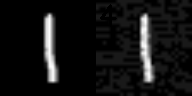

-1

In [14]:
from google.colab.patches import cv2_imshow
# 원본 이미지와 적대적 이미지에 대한 예측된 라벨을 결정한다.
imagePred=label.argmax()
adversaryPred=pred[0].argmax()
color=(0,255,0)

#만약 이미지 예측이 적대적 예측과 일치하지 않는 경우
#예측 후 색상 업데이트
if imagePred != adversaryPred:
  color=(0,0,255)

# 각 출력 이미지에 대한 예측을 그립니다.
cv2.putText(image, str(imagePred),(2,25),
            cv2.FONT_HERSHEY_SIMPLEX,0.95,(0,255,0),2)

cv2.putText(adversary, str(adversaryPred),(2,25),
            cv2.FONT_HERSHEY_SIMPLEX,0.95,color,2)

# 수평적으로 두 이미지를 쌓고 원본 이미지와 적대적 이미지를 보여준
output = np.hstack([image, adversary])
cv2_imshow( output)
cv2.waitKey(0)#입력을 기다리는??

In [15]:
from google.colab.patches import cv2_imshow
import cv2

#10번 반복한다
for _ in range(10):
  #테스트 이미지들 중에서 무작위로 샘플링
  i=np.random.choice(np.arange(0,len(testX)))

  #현재 이미지와 라벨을 가져오기
  image=testX[i]
  label=testY[i]

  #현재 이미지에 대한 적대적 이미지를 생성하고
  #적대적 이미지에 대한 예측 수행
  adversary=generate_image_adversary(model,image.reshape(1,28,28,1),label,eps=0.1)
  pred=model.predict(adversary)

  #원본 이미지와 적대적 이미지를 원하는 범위로 크기 조정
  #[0,255]와 8비트 정수로 변환
  adversary = adversary.reshape((28, 28)) * 255
  adversary = np.clip(adversary, 0, 255).astype("u  int8")
  image = image.reshape((28, 28)) * 255
  image = image.astype("uint8")
    # 이미지와 적대적 이미지를 회색에서 3으로 변환
    # 연결 시킨다.(그래야 그릴 수 있)
    image = np.dstack([image] * 3)
    adversary = np.dstack([adversary] * 3)

    # 이미지의 크기를 조정해서 더 잘볼 수 있게 한다.
    image = cv2.resize(image, (96, 96))
    adversary = cv2.resize(adversary, (96, 96))

    # Determine the predicted labels for the original image and the adversarial image.
    imagePred = label.argmax()
    adversaryPred = pred[0].argmax()
    color = (0, 255, 0)

    # If the image prediction does not match the adversarial prediction,
    # update color after prediction
    if imagePred != adversaryPred:
        color = (0, 0, 255)

    # Draw predictions for each output image.
    cv2.putText(image, str(imagePred), (2, 25),
                cv2.FONT_HERSHEY_SIMPLEX, 0.95, (0, 255, 0), 2)

    cv2.putText(adversary, str(adversaryPred), (2, 25),
                cv2.FONT_HERSHEY_SIMPLEX, 0.95, color, 2)

    # Stack the two images horizontally and show the original image and the hostile image.
    output = np.hstack([image, adversary])
    cv2_imshow(output)
    cv2.waitKey(0)

IndentationError: unexpected indent (<ipython-input-15-8bfb4c5781d3>, line 26)

1/1 [==============================] - 0s 27ms/step


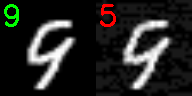

1/1 [==============================] - 0s 25ms/step


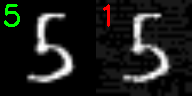

1/1 [==============================] - 0s 25ms/step


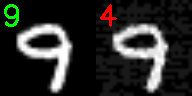

1/1 [==============================] - 0s 25ms/step


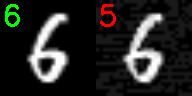

1/1 [==============================] - 0s 24ms/step


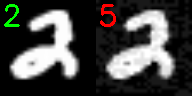

1/1 [==============================] - 0s 23ms/step


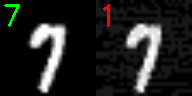

1/1 [==============================] - 0s 23ms/step


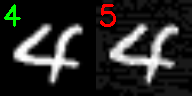

1/1 [==============================] - 0s 28ms/step


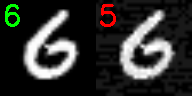

1/1 [==============================] - 0s 21ms/step


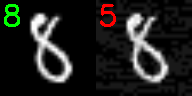

1/1 [==============================] - 0s 22ms/step


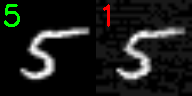

In [16]:
from google.colab.patches import cv2_imshow
import cv2

# Repeat the process 10 times
for _ in range(10):
    # 테스트 이미지들 중에서 무작위로 샘플링
    i = np.random.choice(np.arange(0, len(testX)))

    # 현재 이미지와 라벨을 가져오기.
    image = testX[i]
    label = testY[i]

    # 현재 이미지에 대한 적대적 이미지를 생성하고
    # 적대적에 대한 예측
    adversary = generate_image_adversary(model, image.reshape(1, 28, 28, 1), label, eps=0.1)
    pred = model.predict(adversary)

    # 원본 이미지와 적대적 이미지를 원하는 범위로 크기 조정
    # [0,255]와 8비트 정수로 변환한다.
    adversary = adversary.reshape((28, 28)) * 255
    adversary = np.clip(adversary, 0, 255).astype("uint8")
    image = image.reshape((28, 28)) * 255
    image = image.astype("uint8")

    # 이미지와 적대적 이미지를 회색에서 3으로 변환
    # 연결 시킨다.(그래야 그릴 수 있)
    image = np.dstack([image] * 3)
    adversary = np.dstack([adversary] * 3)

    # 이미지의 크기를 조정해서 더 잘볼 수 있게 한다.
    image = cv2.resize(image, (96, 96))
    adversary = cv2.resize(adversary, (96, 96))

    # Determine the predicted labels for the original image and the adversarial image.
    imagePred = label.argmax()
    adversaryPred = pred[0].argmax()
    color = (0, 255, 0)

    # If the image prediction does not match the adversarial prediction,
    # update color after prediction
    if imagePred != adversaryPred:
        color = (0, 0, 255)

    # Draw predictions for each output image.
    cv2.putText(image, str(imagePred), (2, 25),
                cv2.FONT_HERSHEY_SIMPLEX, 0.95, (0, 255, 0), 2)

    cv2.putText(adversary, str(adversaryPred), (2, 25),
                cv2.FONT_HERSHEY_SIMPLEX, 0.95, color, 2)

    # Stack the two images horizontally and show the original image and the hostile image.
    output = np.hstack([image, adversary])
    cv2_imshow(output)
    cv2.waitKey(0)